In [110]:
import numpy as np
import time
import matplotlib.pyplot as plt
from math import comb
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.optimize import minimize

#-----------------------------
# Parameters
#-----------------------------

# Ego-agent boundary conditions
x0 = np.array([0.0,0.0])
v0 = np.array([0.0,1.0])
a0 = np.array([0.0,0.0])
xf = np.array([5.0,5.0])
vf = np.array([0.0,0.0])
af = np.array([0.0,0.0])

# Obstacle boundary conditions & time
x0_obs = np.array([1.0,3.0])
v0_obs = np.array([-0.3,0.3])
a0_obs = np.array([0.0,0.0])
xf_obs = np.array([0.0,4.0])
vf_obs = np.array([0.0,0.0])
af_obs = np.array([0.0,0.0])
T_obs   = 10.0

# Static constraints
A_stat = np.array([[ -2.0, 0.0],
                   [ -1.0, 1.0],
                   [  0.0, 1.0]])
b_stat = np.array([-1.0, 2.5, 4.0])

# Static box for visualization
box_x, box_y, box_w, box_h = 1.0, 2.0, 1.0, 1.0

# Global waypoints
global_wps = np.array([[0.0,0.0],
                       [0.0,3.0],
                       [2.0,5.0],
                       [5.0,5.0]])

# Number of segments M
M = 3  # number of segments (knots M+1)

# The dynamic constraints
V_max = 2.0  # max velocity
A_max = 10.0  # max acceleration

## sampling grids
N_dyn  = 10
N_jk   = 10

# Generate perturbed waypoints
joint_indices = [1, 2]  # indices of the joints to perturb
num_samples = 10  # number of perturbed waypoint sets to generate
r_min, r_max = 0.3, 1.0  # radius bounds for perturbation

# indices of your 6 free control points:
# (seg,index) pairs for P1_0,P1_1,P1_2,P2_0,P2_1,P2_2
free_cps = [(1,0),(1,1),(1,2),
            (2,0),(2,1),(2,2)]
F = len(free_cps)

# Optimization parameters
time_weight = 10.0
dyn_weight =  10.0
stat_weight = 0.1
jerk_weight = 0.1
dyn_constr_vel_weight = 5.0
dyn_constr_acc_weight = 5.0
bfgs_max_iter = 10
Cw = 1.0   # desired clearance for reciprocal collision avoidance
c  = 2.0   # ellipsoid factor for reciprocal collision avoidance (z axis)


In [111]:
#------------------------------
# Functions
#------------------------------

def bernstein(n, j, tau):
    return comb(n, j) * (tau**j) * ((1-tau)**(n-j))

def eval_traj_and_derivs(CP, T, num_samples):
    """
    Returns pts, vels, accs each of shape (num_samples, 2)
    for a composite quintic Bézier in R^2.
    """
    M = CP.shape[0]
    total_time = np.sum(T)
    t_abs = np.linspace(0.0, total_time, num_samples)
    
    # cumulative end‐times
    ends = np.cumsum(T)
    pts = np.zeros((num_samples,2))
    vels = np.zeros((num_samples,2))
    accs = np.zeros((num_samples,2))
    
    for k, ti in enumerate(t_abs):
        # find segment index
        seg = np.searchsorted(ends, ti, side='right')
        if seg>=M: seg=M-1
        t0 = ends[seg-1] if seg>0 else 0.0
        Ti = T[seg]
        tau = (ti - t0) / Ti
        
        P = CP[seg]  # (6,2)
        # --- position ---
        p = np.zeros(2)
        for j in range(6):
            p += P[j] * bernstein(5, j, tau)
        pts[k] = p
        
        # --- velocity ---
        v = np.zeros(2)
        for j in range(5):
            v += (P[j+1] - P[j]) * bernstein(4, j, tau)
        vels[k] = (5.0 / Ti) * v
        
        # --- acceleration ---
        a = np.zeros(2)
        for j in range(4):
            a += (P[j+2] - 2*P[j+1] + P[j]) * bernstein(3, j, tau)
        accs[k] = (20.0 / (Ti**2)) * a
        
    return pts, vels, accs

def softplus(x):
    # stable softplus: log(1+exp(x)) without overflow
    return np.where(
        x > 0,
        x + np.log1p(np.exp(-x)),
        np.log1p(np.exp(x))
    )

# --- 1) reconstruction: free CPs → full CP array + Ts ---
def reconstruct(z, x0, v0, a0, xf, vf, af, wps):
    """
    Build CP (M×6×2) and final durations T from:
      z = [free CPs (F×2), slacks (M)]
    Boundary conds: x0,v0,a0 and xf,vf,af.
    Free CPs located at free_cps = [(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)].
    """
    # 1) unpack
    ptr     = 0
    cp_free = z[ptr:ptr+2*F].reshape(F,2); ptr += 2*F
    sig     = z[ptr:ptr+M];                ptr += M

    # 2) provisional times
    
    # To avoid T goes to zero, we add min time to each segment
    t_mins = np.zeros(M)
    for i in range(M-1):
        t_mins[i] = np.linalg.norm(wps[i+1] - wps[i]) / V_max  # minimum time for segment i

    T = softplus(sig)               # (M,) purely from slack
    T = T + t_mins  # add minimum time to each segment

    # 3) allocate and inject free CPs
    CP = np.zeros((M,6,2))
    for (seg,i), pt in zip(free_cps, cp_free):
        CP[seg,i] = pt

    # 4) boundary‐injection using T
    # segment 0:
    t0 = T[0]
    CP[0,0] = x0
    CP[0,1] = x0 + (t0/5.0)*v0
    CP[0,2] = x0 + (2*t0/5.0)*v0 + (t0**2/20.0)*a0
    # segment M-1:
    tM = T[-1]
    CP[-1,5] = xf
    CP[-1,4] = xf - (tM/5.0)*vf
    CP[-1,3] = xf - (2*tM/5.0)*vf + (tM**2/20.0)*af

    # 5) enforce C2 at interior joints
    # assume T is your array of segment durations
    for i in range(M-1):
        # 1) pos
        CP[i,5] = CP[i+1,0]
        # 2) vel
        ratio = T[i]/T[i+1]
        CP[i,4] = CP[i,5] - ratio * (CP[i+1,1] - CP[i+1,0])
        # 3) acc
        sec = CP[i+1,2] - 2*CP[i+1,1] + CP[i+1,0]
        CP[i,3] = 2*CP[i,4] - CP[i,5] + ratio**2 * sec

    return CP, T

def eval_traj(CP, T, num_samples):
    M = CP.shape[0]
    total_time = np.sum(T)
    # 1) global times
    t_abs = np.linspace(0.0, total_time, num_samples)
    # 2) cumulative end‐times
    ends = np.cumsum(T)               # [T0, T0+T1, T0+T1+T2, ...]
    pts  = np.zeros((num_samples, 2))

    for k, ti in enumerate(t_abs):
        # 3) segment index: first j so ends[j] > ti
        j = np.searchsorted(ends, ti, side='right')
        if j >= M:
            j = M-1   # clamp exactly at final endpoint

        # 4) segment start = ends[j-1] if j>0 else 0
        t_start = ends[j-1] if j>0 else 0.0
        tau     = (ti - t_start) / T[j]

        # Bernstein basis for quintic
        B = np.array([
            (1-tau)**5,
            5*tau*(1-tau)**4,
            10*tau**2*(1-tau)**3,
            10*tau**3*(1-tau)**2,
            5*tau**4*(1-tau),
            tau**5
        ])
        pts[k] = B @ CP[j]
        # print(f"debug: T vector: {T}, current idx {k}, the current time {ti} falls in segment {j} with tau={tau:.3f} and pts={pts[k]}")
    return pts

def check_continuity(CP, T, tol=1e-6):
    """
    Checks C0, C1, and C2 continuity errors at segment joints for a composite quintic Bézier.

    Inputs:
      CP  : array of shape (M,6,dim) control points for M segments
      T   : array of shape (M,) segment durations
      tol : float, tolerance for continuity

    Prints a table of errors and returns a dict of errors.

    Returns:
      errors: dict with keys 'pos', 'vel', 'acc', each a list of length M-1
    """
    M = CP.shape[0]
    errors = {'pos': [], 'vel': [], 'acc': []}

    for i in range(M-1):
        # Position continuity
        p_end   = CP[i, 5]
        p_start = CP[i+1, 0]
        e_pos = np.linalg.norm(p_end - p_start)

        # Velocity continuity
        v_end   = 5.0 / T[i]   * (p_end - CP[i, 4])
        v_start = 5.0 / T[i+1] * (CP[i+1, 1] - p_start)
        e_vel = np.linalg.norm(v_end - v_start)

        # Acceleration continuity
        a_end   = 20.0 / (T[i]**2)   * (p_end - 2*CP[i, 4] + CP[i, 3])
        a_start = 20.0 / (T[i+1]**2) * (CP[i+1, 2] - 2*CP[i+1, 1] + p_start)
        e_acc = np.linalg.norm(a_end - a_start)

        errors['pos'].append(e_pos)
        errors['vel'].append(e_vel)
        errors['acc'].append(e_acc)

    # Print results
    print(f"{'Joint':^5} | {'C0 error':^10} | {'C1 error':^10} | {'C2 error':^10} | Status")
    print("-"*55)
    for i in range(M-1):
        status = []
        if errors['pos'][i] > tol: status.append('C0✗')
        if errors['vel'][i] > tol: status.append('C1✗')
        if errors['acc'][i] > tol: status.append('C2✗')
        stat_str = ','.join(status) if status else 'OK'
        print(f"{i:^5} | {errors['pos'][i]:^10.2e} | {errors['vel'][i]:^10.2e} | {errors['acc'][i]:^10.2e} | {stat_str}")

    return errors

# Reuse previously defined fit_quintic
def fit_quintic(x0, v0, a0, xf, vf, af, T):
    A = np.zeros((6,6))
    bx = np.zeros(6); by = np.zeros(6)
    # p(0)=x0
    A[0,0]=1; bx[0],by[0]=x0
    # p'(0)=v0
    A[1,1]=1; bx[1],by[1]=v0
    # p''(0)=a0 => 2c2=a0
    A[2,2]=2; bx[2],by[2]=a0
    # p(T)=xf
    for i in range(6): A[3,i]=T**i
    bx[3],by[3]=xf
    # p'(T)=vf
    for i in range(1,6): A[4,i]=i*T**(i-1)
    bx[4],by[4]=vf
    # p''(T)=af
    for i in range(2,6): A[5,i]=i*(i-1)*T**(i-2)
    bx[5],by[5]=af
    cx = np.linalg.solve(A, bx)
    cy = np.linalg.solve(A, by)
    return cx, cy

# Define dynamic-obstacle function
def f_obs_poly(t, c_x_obs, c_y_obs):
    t = np.array(t)
    # broadcast to same shape
    px = sum(c_x_obs[i]*t**i for i in range(6))
    py = sum(c_y_obs[i]*t**i for i in range(6))
    return np.vstack([px, py]).T

def sample_systematic_perturbed_waypoints(global_wps, joint_indices,
                                          N, r_min, r_max,
                                          constraint_sets):
    """
    Systematically perturb only the joint waypoints by the same (r,±) pair.

    Args:
      global_wps    : array (K,2) of original waypoints
      joint_indices : list of ints in [1..K-2] to perturb
      N             : total desired samples (will use floor(N/2) per sign)
      r_min, r_max  : radius bounds
      A             : (m×2) matrix for A @ x <= b
      b             : (m,)   vector for A @ x <= b

    Returns:
      samples       : array (M, K, 2) of perturbed waypoint sets,
                      where M ≤ N (invalid ones dropped)
    """
    K, _ = global_wps.shape
    half = N // 2
    # 1) build the evenly spaced radii
    radii = np.linspace(r_min, r_max, half)

    # 2) precompute bisector-normals at each joint
    normals = []
    for idx in joint_indices:
        d1 = global_wps[idx]   - global_wps[idx-1]
        d2 = global_wps[idx+1] - global_wps[idx]
        n1 = np.array([-d1[1], d1[0]]) / np.linalg.norm(d1)
        n2 = np.array([-d2[1], d2[0]]) / np.linalg.norm(d2)
        bis = n1 + n2
        if np.linalg.norm(bis) < 1e-8:
            bis = n1
        else:
            bis = bis / np.linalg.norm(bis)
        normals.append(bis)
    normals = np.vstack(normals)  # shape (J,2)

    samples = []
    # 3) loop over sign and r
    for sign in (-1.0, +1.0):
        for r in radii:
            cand = global_wps.copy()
            ok = True
            # perturb each joint
            for j, idx in enumerate(joint_indices):
                xj = global_wps[idx] + sign * r * normals[j]
                # check linear constraints
                for A, b in constraint_sets[j]:
                    if np.any(A.dot(xj) <= b):
                        ok = False
                        break
                cand[idx] = xj
            if ok:
                samples.append(cand)

    return np.array(samples)  # shape (M, K, 2)

# Plot the velocity and acceleration profiles over time
def plot_velocity_acceleration(CP, T, num_samples=100):
    pts, velocities, accelerations = eval_traj_and_derivs(CP, T, num_samples)

    plt.figure(figsize=(12, 6))
    
    # Plot velocity
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, T.sum(), num_samples), velocities, label=['Vx', 'Vy'])
    plt.title('Velocity Profile')
    plt.xlabel('Time')
    plt.ylabel('Velocity')          
    plt.legend()
    plt.grid(True)
    # Plot acceleration
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, T.sum(), num_samples), accelerations, label=['Ax', 'Ay'])
    plt.title('Acceleration Profile')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the trajectory
def plot_trajectory(original_global_wps, sampled_wps, 
                    A_stat, b_stat, box_x, box_y, box_w, box_h,
                    x0, v0, xf, T_obs, c_x_obs, c_y_obs,
                    list_cp0, list_t0):

    # Plot everything
    plt.figure(figsize=(6,6))

    # 1) Static box
    plt.gca().add_patch(plt.Rectangle((box_x,box_y),box_w,box_h, 
                                    facecolor='black',alpha=0.3, label='Static Box'))

    # 2) Hyperplanes
    x_vals = np.linspace(-1,6,200)
    for i,(a,b) in enumerate(zip(A_stat,b_stat)):
        if abs(a[1])>1e-3:
            y_vals = (b - a[0]*x_vals)/a[1]
            plt.plot(x_vals,y_vals,'r-', lw=1, label='Hyperplane' if i==0 else None)
        else:
            xm = b/a[0]
            plt.plot([xm,xm],[-1,6],'r-', lw=1, label='Hyperplane' if i==0 else None)
        # arrow
        if abs(a[1])>1e-3:
            xm = 2.0; ym = (b - a[0]*xm)/a[1]
        else:
            xm = b/a[0]; ym = 2.5
        n = a/np.linalg.norm(a)
        plt.arrow(xm,ym,n[0]*0.5,n[1]*0.5,head_width=0.1,head_length=0.1,color='r')

    # 3) Global path
    plt.plot(original_global_wps[:,0],original_global_wps[:,1],'bo--',label='Global Path')

    # 4) Sampled perturbed waypoints
    for i in range(sampled_wps.shape[0]):
        plt.plot(sampled_wps[i,:,0], sampled_wps[i,:,1], 'k--', alpha=0.3)
    plt.scatter(sampled_wps[:,1,0], sampled_wps[:,1,1], c='k', s=10, label='Perturbed WPs')
    plt.scatter(sampled_wps[:,2,0], sampled_wps[:,2,1], c='k', s=10)

    # 4) Start/Goal + init velocity
    plt.scatter(x0[0],x0[1],c='green',s=100,label='Start')
    plt.arrow(x0[0],x0[1],v0[0],v0[1],head_width=0.1,head_length=0.1,fc='green',ec='green')
    plt.scatter(xf[0],xf[1],c='red',s=100,label='Goal')

    # 5) Dynamic obstacle polynomial
    t_samples = np.linspace(0,T_obs,N_dyn)
    t_dense   = np.linspace(0,T_obs,200)
    obs_dense = f_obs_poly(t_dense, c_x_obs, c_y_obs)
    obs_samp  = f_obs_poly(t_samples, c_x_obs, c_y_obs)
    plt.plot(obs_dense[:,0],obs_dense[:,1],'--',color='orange',lw=2,label='Dyn Obs Poly')
    plt.scatter(obs_samp[:,0],obs_samp[:,1],c='k')
    for (x,y),t in zip(obs_samp,t_samples):
        plt.text(x,y+0.05,f'{t:.1f}',ha='center',va='bottom',fontsize=8)

    # Loop thru each initial guess
    for idx, (cp0, t0) in enumerate(zip(list_cp0, list_t0)):

        # 6) Initial control points (cp0)
        cp0_flat = cp0.reshape(-1,2)
        plt.scatter(cp0_flat[:,0], cp0_flat[:,1], c='purple', s=50, label='Init CPs' if idx==0 else None)
        for i in range(M):
            plt.plot(cp0[i,:,0], cp0[i,:,1], 'purple', lw=1, alpha=0.5)

        # 7) Original initial guess trajectory 
        t = np.linspace(0, t0.sum(), 100)
        pts_init = eval_traj(cp0, t0, 100)
        plt.plot(pts_init[:,0], pts_init[:,1], 'g-', lw=2, label='Initial Trajectory' if idx==0 else None)
    
    plt.axis('equal'); #plt.xlim(-1,6); plt.ylim(-1,6)
    plt.xlabel('X'); plt.ylabel('Y')
    plt.legend(); plt.grid(True)
    plt.title('Full Setup: Box, Global Path, Hyperplanes, Dynamic Obs')
    plt.show()


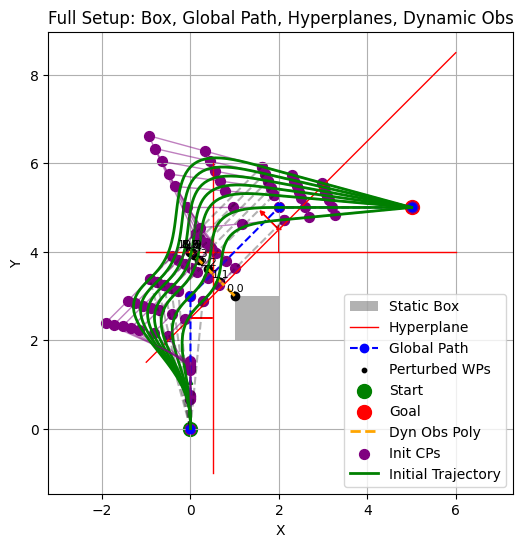

In [119]:
constraint_sets = []
for i in range(2):
    sets = [(A_stat[i], b_stat[i]), (A_stat[i+1], b_stat[i+1])]
    constraint_sets.append(sets)

# Compute the constraints for the perturbed waypoints
sampled_wps = sample_systematic_perturbed_waypoints(
    global_wps, joint_indices,
    num_samples, r_min, r_max,
    constraint_sets
)

# reshape global waypoints which has (K,2) shape to (1, K, 2) shape
original_global_wps = global_wps.copy()
global_wps_reshaped = global_wps.reshape(1, -1, 2)
# Stack sampled waypoints to global_wps
global_wps_stacked = np.vstack([global_wps_reshaped, sampled_wps])

# 1) control‐point initial guesses
list_z0 = []  # list of initial guesses for z0
list_cp0 = []  # list of initial guesses for control points
list_t0 = []  # list of initial guesses for segment durations

for gwp in global_wps_stacked:
    init_cp = []
    for seg, j in free_cps:
        P_start = gwp[seg]
        P_end   = gwp[seg+1]
        tau_j   = j / 5.0                    # for quintic, j=0..5 because it has 6 control points
        init_cp.append(P_start + tau_j*(P_end - P_start))
    init_cp = np.array(init_cp)             # shape (F,2)

    # 2) slack‐time initial guesses
    # segment distances
    dists = np.linalg.norm(gwp[1:] - gwp[:-1], axis=1)  # length M
    t_nom = dists / V_max         
    # invert softplus: T = softplus(sigma) + t_nom => sigma = log(e^(T-t_nom) + 1)
    # say we want T to be C_T times the nominal time
    # (C_T - 1) * t_nom  = softplus(sigma) => sigma = log(e^((C_T - 1) * t_nom) + 1)
    # clamp inside of log for numerical safety
    eps_clamp = 1e-3
    t_nom = np.maximum(t_nom, eps_clamp)
    C_T = 2.0  # desired time factor
    init_sigma = np.log(np.exp((C_T - 1) * t_nom) + 1)  # shape (M,)

    # # initial sigma can be very small 
    # init_sigma = 4 * np.ones(M) # small initial slack times


    # 3) full initial z0
    z0 = np.hstack([init_cp.ravel(), init_sigma])

    # 4) generate the full initial guess (all the control points that can be computed from the boundary conditions and C2 continuity)
    cp0, t0 = reconstruct(z0, x0, v0, a0, xf, vf, af, gwp)

    # 5) store the initial guesses
    list_z0.append(z0)
    list_cp0.append(cp0)
    list_t0.append(t0)

# Plot everything

# Compute polynomial coefficients
c_x_obs, c_y_obs = fit_quintic(x0_obs, v0_obs, a0_obs, xf_obs, vf_obs, af_obs, T_obs)

# define c_z_obs as a constant factor for z-axis
c_z_obs = c_x_obs * 0.0 + c_y_obs * 0.0 + Cw

plot_trajectory(
    original_global_wps, sampled_wps,
    A_stat, b_stat, box_x, box_y, box_w, box_h,
    x0, v0, xf, T_obs, c_x_obs, c_y_obs,
    list_cp0, list_t0
)

# Plot the velocity and acceleration profiles for the initial trajectory
# plot_velocity_acceleration(cp0, t0, num_samples=100)

Run #1: success=False, time=0.22s
Run #2: success=False, time=0.23s
Run #3: success=False, time=0.23s
Run #4: success=False, time=0.23s
Run #5: success=False, time=0.34s
Run #6: success=False, time=0.43s
Run #7: success=False, time=0.47s


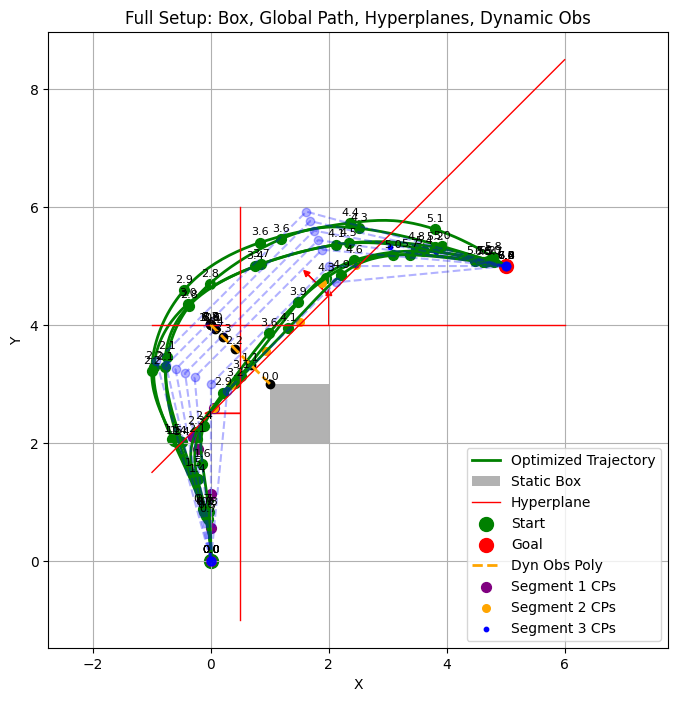

In [139]:
#------------------------------
# Optimization
#------------------------------

# reciprocal avoidance cost
def reciprocal_avoidance_cost(u_pts, k_pts_list, Cw, c):
    """
    Compute the reciprocal avoidance penalty Jw for one “ego” trajectory
    against multiple “other” trajectories.

    Jw = sum_{k} sum_{i} max(Cw^2 - d_w(i)^2, 0)^3
    where
      d_w(i) = || E^{1/2} (u_pts[i] - k_pts_list[k][i]) ||
    and E = diag(1, 1, 1/c).

    Parameters
    ----------
    u_pts : array_like, shape (N, 3)
        Sampled positions of the ego-agent at times {t_i}.
    k_pts_list : list of array_like
        Each element is an (N,3) array of positions of another agent,
        sampled at times aligned with `u_pts`sets.
    Cw : float
        Swarm clearance distance.
    c : float
        Ellipsoid scaling factor on the z-axis (c > 1).

    Returnsvstack([global_wps, sampled_wps.reshape(-1, 2)])
    -------
    Jw : float
        The total reciprocal-avoidance penalty.
    """
    # Precompute E^{1/2} = diag(1, 1, 1/sqrt(c))
    E_half = np.diag([1.0, 1.0, 1.0/np.sqrt(c)])
    
    Jw = 0.0
    Cw2 = Cw**2
    
    for k_pts in k_pts_list:
        # difference vectors shape (N,3)
        diff = u_pts - k_pts  
        # apply ellipsoidal metric: E^{1/2} diff
        diff_ell = diff @ E_half.T  
        # squared distances d_w^2, shape (N,)
        d2 = np.sum(diff_ell**2, axis=1)
        # compute per-sample penalty: max(Cw^2 - d2, 0)^3
        penalties = np.clip(Cw2 - d2, 0.0, None)**3
        # sum over time samples
        Jw += np.sum(penalties)
    
    return Jw

#--- 5) Define the objective function ---
def objective(z):
    """
    Unconstrained joint objective using integer-based eval_traj.
    """
    # 1) Reconstruct full CP and T
    CP, T = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)

    # 2) Global sampling for dynamic + static
    N_samp = M * N_dyn
    pts2d  = eval_traj(CP, T, N_samp)

    # build absolute times and segment indices
    total_time = np.sum(T)
    t_abs = np.linspace(0.0, total_time, N_samp)      # (N_samp,)
    offsets = np.hstack((0.0, np.cumsum(T)[:-1]))     # (M,)
    seg_idx = np.searchsorted(offsets + T, t_abs, side='right') - 1
    seg_idx = np.clip(seg_idx, 0, M-1)

    # 3) Dynamic-obstacle cost
    total_time = np.sum(T)
    t_abs      = np.linspace(0, total_time, N_samp)
    obs2d      = f_obs_poly(t_abs, c_x_obs, c_y_obs)  # (N_samp,2)
    # embed into 3D by adding z=0
    u_pts = np.hstack([pts2d, np.zeros((N_samp,1))]) # (N_samp,3)
    k_pts = np.hstack([obs2d, np.zeros((N_samp,1))]) # (N_samp,3)

    # 4) reciprocal‐avoidance cost against this single “other” trajectory
    dyn_cost = reciprocal_avoidance_cost(u_pts, [k_pts], Cw, c)

    # 4) Per-sample static cost using per-segment separator
    stat_cost = 0.0
    BIG = 1e8
    for seg, idx in free_cps:
        pt = CP[seg, idx]
        if idx == 0 and seg > 0:
            # joint point: enforce both adjacent half‐spaces
            for plane in (seg-1, seg):
                h = A_stat[plane].dot(pt) - b_stat[plane]
                if h <= 0:
                    return BIG
                stat_cost += -np.log(h)
        else:
            # usual per‐segment constraint
            h = A_stat[seg].dot(pt) - b_stat[seg]
            if h <= 0:
                return BIG
            stat_cost += -np.log(h)

    # 5) Jerk penalty via global numeric 3rd derivative
    N_jk_global = M * N_jk
    pts_jk = eval_traj(CP, T, N_jk_global)           # (N_jk_global,2)
    t_jk = np.linspace(0.0, total_time, N_jk_global)
    dt = t_jk[1] - t_jk[0]
    dp  = np.gradient(pts_jk, axis=0) / dt
    ddp = np.gradient(dp,     axis=0) / dt
    jrp = np.gradient(ddp,    axis=0) / dt
    jerk_penalty = np.sum(np.sum(jrp**2, axis=1))

    # 6) Time cost
    time_cost = np.sum(T)

    # 7) Dynamic constraints violation costs
    # velocity constraints
    v_viol = np.maximum(np.linalg.norm(dp, axis=1) - V_max, 0.0)
    v_cost = np.sum(v_viol**2) * dyn_constr_vel_weight
    # acceleration constraints
    a_viol = np.maximum(np.linalg.norm(ddp, axis=1) - A_max, 0.0)
    a_cost = np.sum(a_viol**2) * dyn_constr_acc_weight

    return time_weight * time_cost + dyn_weight * dyn_cost + stat_weight * stat_cost + jerk_weight * jerk_penalty + dyn_constr_vel_weight * v_cost + dyn_constr_acc_weight * a_cost

#--- 6) Run unconstrained BFGS

# initial guess - from the global path, we can 
# --- Build new z0 from global_wps + v_max ---
# free_cps = [(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
# global_wps shape: (M+1,2)
# V_max already defined

def optimize_z0(z0):
    """Run one BFGS solve and record its elapsed time."""
    t0 = time.time()
    res = minimize(objective, z0,
                   method='BFGS',
                   options={'maxiter': bfgs_max_iter})
    t_elapsed = time.time() - t0
    return res, t_elapsed

# measure computation time
results = []
with ProcessPoolExecutor() as exe:
    # schedule all jobs
    futures = [exe.submit(optimize_z0, z0) for z0 in list_z0]

    # as each one completes, grab its result
    for i, fut in enumerate(as_completed(futures), 1):
        res, t_elapsed = fut.result()
        print(f"Run #{i}: success={res.success}, time={t_elapsed:.2f}s")
        results.append(res)

list_z_opt = [res.x for res in results]

#--- 7) Plot results
# trajectory
plt.figure(figsize=(8,8))

for idx, (z_opt, cp0, t0) in enumerate(zip(list_z_opt, list_cp0, list_t0)):

    #--- 8) Extract optimized trajectory
    Q_opt, T_opt = reconstruct(z_opt, x0, v0, a0, xf, vf, af, global_wps)

    taus = np.linspace(0, np.sum(T_opt), 200)
    pts_opt = eval_traj(Q_opt, T_opt, 200)
    plt.plot(pts_opt[:,0], pts_opt[:,1], 'g-', lw=2, label='Optimized Trajectory' if idx==0 else None)

    # Plot time stamps along the trajectory
    N_time_samples = 10
    idx_list = np.linspace(0, len(pts_opt)-1, N_time_samples, dtype=int)
    for idx in idx_list:
        plt.scatter(pts_opt[idx,0], pts_opt[idx,1], c='g', s=50)
        plt.text(pts_opt[idx,0], pts_opt[idx,1]+0.1, f'{taus[idx]:.1f}', ha='center', va='bottom', fontsize=8)

# 1) Static box
plt.gca().add_patch(plt.Rectangle((box_x,box_y),box_w,box_h, 
                                facecolor='black',alpha=0.3, label='Static Box'))

# 2) Hyperplanes
x_vals = np.linspace(-1,6,200)
for i,(a,b) in enumerate(zip(A_stat,b_stat)):
    if abs(a[1])>1e-3:
        y_vals = (b - a[0]*x_vals)/a[1]
        plt.plot(x_vals,y_vals,'r-', lw=1, label='Hyperplane' if i==0 else None)
    else:
        xm = b/a[0]
        plt.plot([xm,xm],[-1,6],'r-', lw=1, label='Hyperplane' if i==0 else None)
    # arrow
    if abs(a[1])>1e-3:
        xm = 2.0; ym = (b - a[0]*xm)/a[1]
    else:
        xm = b/a[0]; ym = 2.5
    n = a/np.linalg.norm(a)
    plt.arrow(xm,ym,n[0]*0.5,n[1]*0.5,head_width=0.1,head_length=0.1,color='r')

# 3) Global path
for gwp in global_wps_stacked:
    plt.plot(gwp[:,0], gwp[:,1], 'bo--', alpha=0.3, label='Global Path' if gwp is global_wps[0] else None)

# 4) Start/Goal + init velocity
plt.scatter(x0[0],x0[1],c='green',s=100,label='Start')
plt.arrow(x0[0],x0[1],v0[0],v0[1],head_width=0.1,head_length=0.1,fc='green',ec='green')
plt.scatter(xf[0],xf[1],c='red',s=100,label='Goal')

# 5) Dynamic obstacle polynomial
t_samples = np.linspace(0,T_obs,N_dyn)
t_dense   = np.linspace(0,T_obs,200)
obs_dense = f_obs_poly(t_dense, c_x_obs, c_y_obs)
obs_samp  = f_obs_poly(t_samples, c_x_obs, c_y_obs)
plt.plot(obs_dense[:,0],obs_dense[:,1],'--',color='orange',lw=2,label='Dyn Obs Poly')
plt.scatter(obs_samp[:,0],obs_samp[:,1],c='k')
for (x,y),t in zip(obs_samp,t_samples):
    plt.text(x,y+0.05,f'{t:.1f}',ha='center',va='bottom',fontsize=8)

# 6) Control points (use three different colors for each segment)
cp_opt_flat = Q_opt.reshape(-1,2)
# first segment
plt.scatter(cp_opt_flat[:6,0], cp_opt_flat[:6,1], c='purple', s=50, label='Segment 1 CPs')
# second segment
plt.scatter(cp_opt_flat[6:12,0], cp_opt_flat[6:12,1], c='orange', s=30, label='Segment 2 CPs')
# third segment
plt.scatter(cp_opt_flat[12:,0], cp_opt_flat[12:,1], c='blue', s=10, label='Segment 3 CPs')

plt.axis('equal'); #plt.xlim(-1,6); plt.ylim(-1,6)
plt.xlabel('X'); plt.ylabel('Y')
plt.legend(); plt.grid(True)
plt.title('Full Setup: Box, Global Path, Hyperplanes, Dynamic Obs')
plt.show()

# Plot the velocity and acceleration profiles for the initial trajectory
# plot_velocity_acceleration(Q_opt, T_opt, num_samples=1000)

In [140]:
# Custom made L-BFGS solver

import numpy as np

class LBFGSParameter:
    def __init__(self,
                 mem_size=8,
                 g_epsilon=1e-5,
                 past=3,
                 delta=1e-6,
                 max_iterations=0,
                 max_linesearch=64,
                 min_step=1e-20,
                 max_step=1e+20,
                 f_dec_coeff=1e-4,
                 s_curv_coeff=0.9,
                 cautious_factor=1e-6,
                 machine_prec=1e-16):
        self.mem_size = mem_size
        self.g_epsilon = g_epsilon
        self.past = past
        self.delta = delta
        self.max_iterations = max_iterations
        self.max_linesearch = max_linesearch
        self.min_step = min_step
        self.max_step = max_step
        self.f_dec_coeff = f_dec_coeff
        self.s_curv_coeff = s_curv_coeff
        self.cautious_factor = cautious_factor
        self.machine_prec = machine_prec

def lbfgs_optimize(x0, func, grad, params=None, callback=None):
    """
    x0:        initial guess, 1D numpy array
    func(x):  returns scalar f
    grad(x):  returns gradient array same shape as x
    params:   LBFGSParameter instance
    callback: optional fn(x, g, f, step, k, ls) → if returns True, stops early
    """
    if params is None:
        params = LBFGSParameter()
    # memories
    S, Y, YS = [], [], []
    pf = []  # past function values
    x = x0.astype(float).copy()
    n = x.size

    # initial eval
    f = func(x)
    g = grad(x)
    pf.append(f)

    # initial direction
    d = -g
    k = 0
    status = 0

    def inf_norm(v):
        return np.max(np.abs(v))

    # check initial convergence
    if inf_norm(g) / max(1, inf_norm(x)) <= params.g_epsilon:
        return x, f, g, {'status':'converged','iterations':0}

    while True:
        k += 1
        xp, gp = x.copy(), g.copy()
        f0, dg0 = f, gp.dot(d)

        # line search
        step = 1.0 / max(1e-8, np.linalg.norm(d))
        step = min(step, params.max_step)
        ls_count = 0
        while ls_count < params.max_linesearch:
            x_new = xp + step * d
            f_new = func(x_new)
            if np.isnan(f_new) or np.isinf(f_new):
                status = 'func_nan'
                x, g, f = xp, gp, f0
                break
            # Armijo
            if f_new > f0 + params.f_dec_coeff * step * dg0:
                step *= 0.5
            else:
                g_new = grad(x_new)
                # weak Wolfe
                if g_new.dot(d) < params.s_curv_coeff * dg0:
                    step *= 1.1
                else:
                    x, f, g = x_new, f_new, g_new
                    status = 'ls_ok'
                    break
            if step < params.min_step:
                status = 'min_step'
                x, g, f = xp, gp, f0
                break
            ls_count += 1
        else:
            status = 'ls_max'

        if callback is not None and callback(x, g, f, step, k, ls_count):
            return x, f, g, {'status':'canceled','iterations':k}

        # convergence test
        if inf_norm(g) / max(1, inf_norm(x)) < params.g_epsilon:
            return x, f, g, {'status':'converged','iterations':k}

        # past-delta test
        pf.append(f)
        if len(pf) > params.past:
            rate = abs(pf[-params.past-1] - pf[-1]) / max(1, abs(f))
            if rate < params.delta:
                return x, f, g, {'status':'stopped','iterations':k}

        if params.max_iterations and k >= params.max_iterations:
            return x, f, g, {'status':'max_iterations','iterations':k}

        # update s,y memory
        s = x - xp
        y = g - gp
        ys = y.dot(s)
        yy = y.dot(y)
        if ys > params.cautious_factor * (np.linalg.norm(s)**2) * np.linalg.norm(g):
            if len(S) == params.mem_size:
                S.pop(0); Y.pop(0); YS.pop(0)
            S.append(s); Y.append(y); YS.append((ys, yy))

        # two-loop recursion to get new direction
        q = -g.copy()
        alpha = []
        for (s_i, y_i, (ys_i, _)) in zip(reversed(S), reversed(Y), reversed(YS)):
            rho = 1.0/ys_i
            a = rho * s_i.dot(q)
            alpha.append(a)
            q -= a * y_i
        # scale by gamma = ys_last/yy_last
        if YS:
            gamma = YS[-1][0]/YS[-1][1]
        else:
            gamma = 1.0
        r = gamma * q
        for (s_i, y_i, (ys_i, _)), a in zip(zip(S, Y, YS), reversed(alpha)):
            rho = 1.0/ys_i
            beta = rho * y_i.dot(r)
            r += s_i * (a - beta)
        d = r

    # unreachable
    return x, f, g, {'status':'error','iterations':k}

# Example usage: minimize f(x)=½ x^T A x - b^T x
# if __name__ == "__main__":
#     n = 5
#     A = np.diag(np.arange(1, n+1))
#     b = np.ones(n)*0.5
#     def f_quad(x):     return 0.5*x.dot(A.dot(x)) - b.dot(x)
#     def g_quad(x):     return A.dot(x) - b

#     x0 = np.zeros(n)
#     x_opt, f_val, g_val, info = lbfgs_optimize(x0, f_quad, g_quad)
#     print("x* =", x_opt)
#     print("f* =", f_val)
#     print("info:", info)


In [143]:
import numpy as np
from scipy.optimize import approx_fprime

# assume all of these are already defined in your notebook:
# reconstruct, eval_traj_and_derivs, f_obs_poly,
# free_cps, A_stat, b_stat, Cw, c, V_max, A_max,
# time_weight, dyn_weight, stat_weight, jerk_weight,
# dyn_constr_vel_weight, dyn_constr_acc_weight

def compute_objective(z):
    # 1) reconstruct full CP and T
    CP, T = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)

    # 2) --- time cost ---
    J_time = np.sum(T)

    # 3) --- dynamic-obstacle cost ---
    N_samp = M * N_dyn
    # sample ego trajectory in 2D
    pts, _, _ = eval_traj_and_derivs(CP, T, N_samp)  # (N_samp×3)
    # times
    t_abs = np.linspace(0.0, np.sum(T), N_samp)
    # for each obstacle k (here only one)
    J_dyn = 0.0

    # **** Modified here for 2D version **** #
    for (c_x_k, c_y_k, c_z_k) in [(c_x_obs, c_y_obs, c_z_obs)]:
        # k_pts = f_obs_poly(t_abs, c_x_k, c_y_k, c_z_k)
        k_pts = f_obs_poly(t_abs, c_x_k, c_y_k)
        # ellipsoid metric
        # E_half = np.diag([1.0,1.0,1.0/np.sqrt(c)])
        E_half = np.diag([1.0,1.0])
        diff   = (pts - k_pts) @ E_half.T
        d2     = np.sum(diff**2, axis=1)
        # penalty max(Cw^2−d2,0)^3
        J_dyn += np.sum(np.clip(Cw**2 - d2, 0.0, None)**3)

    # 4) --- static-obstacle barrier cost ---
    BIG = 1e8
    J_stat = 0.0
    for (seg, idx) in free_cps:
        P = CP[seg, idx]
        planes = [seg] if not (idx==0 and seg>0) else [seg-1,seg]
        for p in planes:
            h = A_stat[p].dot(P) - b_stat[p]
            if h <= 0:
                return BIG  # infeasible
            J_stat += -np.log(h)

    # 5) --- jerk penalty ---
    J_jerk = 0.0
    for s in range(M):
        # third finite differences:
        Δ3 = np.vstack([
            CP[s,3] - 3*CP[s,2] + 3*CP[s,1] - CP[s,0],
            CP[s,4] - 3*CP[s,3] + 3*CP[s,2] - CP[s,1],
            CP[s,5] - 3*CP[s,4] + 3*CP[s,3] - CP[s,2],
        ])  # shape (3,3)
        J_jerk += (3600.0 / T[s]**5) * np.sum(Δ3**2)

    # 6) --- dynamic-constraint violation cost ---
    # sample velocity & acceleration
    pts_vel, vels, accs = eval_traj_and_derivs(CP, T, M * N_dyn)
    vel_viol = np.maximum(np.linalg.norm(vels,axis=1) - V_max, 0.0)
    acc_viol = np.maximum(np.linalg.norm(accs,axis=1) - A_max, 0.0)
    J_vel_constr = dyn_constr_vel_weight * np.sum(vel_viol**2)
    J_acc_constr = dyn_constr_acc_weight * np.sum(acc_viol**2)

    # weighted sum
    return (
        time_weight      * J_time
      + dyn_weight       * J_dyn
      + stat_weight      * J_stat
      + jerk_weight      * J_jerk
      + dyn_constr_vel_weight * J_vel_constr
      + dyn_constr_acc_weight * J_acc_constr
    )

def compute_auto_grad(z, eps=1e-6):
    """
    Numerically approximate ∇J(z) via central finite differences.
    This is ~3× slower than forward, but more accurate.
    """
    f0 = compute_objective(z)
    grad = np.zeros_like(z)
    ei   = np.zeros_like(z)
    for i in range(z.size):
        ei[:] = 0.0
        ei[i] = eps
        f_plus  = compute_objective(z + ei)
        f_minus = compute_objective(z - ei)
        grad[i] = (f_plus - f_minus) / (2*eps)
    return grad

import numpy as np

def compute_analytical_grad(z):
    """
    Compute ∇J(z) analytically.
    z packs [free CPs (F×3), slack sigmas (M,)].

    Returns
    -------
    grad : (len(z),) array
    """
    # 1) Reconstruct full controls and times
    CP, T = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)
    Mseg = CP.shape[0]
    Fdim = len(free_cps)*3

    # pre-allocate gradient
    grad = np.zeros_like(z)

    # 2) ∂J_time/∂z : only through T part
    # ∇_σ J_time = w_t * [1 * ∂T/∂σ]

    time_gradient = dJ_time_dsigma(z, T)
    print(f"time gradient: {time_gradient}")
    grad[Fdim:] += time_weight * time_gradient

    # 3) ∂J_dyn/∂z
    dyn_gradient = dJ_dyn_dz(z, CP, T)
    print(f"dyn gradient: {dyn_gradient}")
    grad += dyn_weight * dyn_gradient

    # 4) ∂J_stat/∂z
    stat_gradient = dJ_stat_dz(z, CP, T)
    print(f"stat gradient: {stat_gradient}")
    grad += stat_weight * stat_gradient

    # 5) ∂J_jerk/∂z
    jerk_gradient = dJ_jerk_dz(CP, T)
    print(f"jerk gradient: {jerk_gradient}")
    grad += jerk_weight * jerk_gradient

    # 6) dynamic‐constraint violation
    dyn_constr_vel_gradient = dJ_vel_constr_dz(CP, T)
    print(f"dyn constr vel gradient: {dyn_constr_vel_gradient}")
    grad += dyn_constr_vel_weight * dyn_constr_vel_gradient

    dyn_constr_acc_gradient = dJ_acc_constr_dz(CP, T)
    print(f"dyn constr acc gradient: {dyn_constr_acc_gradient}")
    grad += dyn_constr_acc_weight * dyn_constr_acc_gradient

    return grad

# -------------------------------------------------------------------
# Helpers stubs: fill these with the formulas from our derivations
# -------------------------------------------------------------------

def dJ_time_dsigma(z, T):
    """
    Compute dJ_time / dσ, where
      J_time = sum_r T_r(σ)
      T_r = softplus(σ_r) + t_min_r

    Inputs:
      z : (F*3 + M,) array, packed [free_control_points, σ]
      T : (M,)       array of segment durations, as returned by reconstruct()

    Returns:
      dJ_dsigma : (M,) array with entries ∂J_time/∂σ_r = softplus'(σ_r).
    """
    # how many free‐CP entries at front of z?
    F = len(free_cps)           # number of free control points
    offset = 3 * F              # each free CP has 3 dims

    # extract the slack variables σ_r
    sigma = z[offset : offset + T.shape[0]]   # shape (M,)

    # softplus'(x) = exp(x) / (1 + exp(x)) = sigmoid(x)
    # we use a numerically stable sigmoid:
    #   σ'(x) = 1 / (1 + exp(-x))
    # which is equivalent to exp(x)/(1+exp(x)).
    exp_neg = np.exp(-sigma)
    dT_dsigma = 1.0 / (1.0 + exp_neg)

    # since J_time = sum_r T_r, ∂J_time/∂σ_r = ∂T_r/∂σ_r
    return dT_dsigma

def dJ_dyn_dz(z, CP, T):
    """
    Analytical gradient of J_dyn(z) = sum_i sum_k [max(Cw^2 - d_{i,k}^2,0)]^3
    w.r.t. the decision vector z = [free_CPs, sigmas].

    Returns
    -------
    grad : array_like, shape (len(z),)
    """
    M = T.shape[0]
    # total number of trajectory samples
    N_samp = M * N_dyn

    # pre‐compute times and metric
    total_time = T.sum()
    t_abs = np.linspace(0.0, total_time, N_samp)
    # E = diag(1,1,1/√c); but we need E for squared‐distance
    # E = np.diag([1.0, 1.0, 1.0/c])
    E = np.diag([1.0, 1.0])
    Cw2 = Cw**2

    # forward pass
    u_pts = eval_traj(CP, T, N_samp)                           # (N_samp,3)
    # k_pts = f_obs_poly(t_abs, c_x_obs, c_y_obs, c_z_obs)       # (N_samp,3)
    k_pts = f_obs_poly(t_abs, c_x_obs, c_y_obs)       # (N_samp,2)

    # precompute Jacobians:
    # du_dz[i] = ∂u_i/∂z,   shape (3, len(z))
    # dk_dz[i] = ∂k_i/∂z,   shape (3, len(z))
    du_dz = compute_du_dz(z, CP, T, N_samp, free_cps, global_wps)
    dk_dz = compute_dk_dz(z, T, N_samp, c_x_obs, c_y_obs, c_z_obs)

    grad = np.zeros_like(z)

    for i in range(N_samp):
        diff = u_pts[i] - k_pts[i]                # shape (3,)
        d2   = diff @ (E @ diff)                  # scalar

        if d2 < Cw2:
            # ∂J/∂d2 = d/d2 [(Cw2-d2)^3] = -3 (Cw2 - d2)^2
            pd = -3.0 * (Cw2 - d2)**2

            # ∂d2/∂u = 2 E diff,   ∂d2/∂k = -2 E diff
            grad_u = pd * (2.0 * (E @ diff))       # shape (3,)
            grad_k = -grad_u                       # shape (3,)

            # chain‐rule into z
            # grad += grad_u^T @ (∂u/∂z) + grad_k^T @ (∂k/∂z)
            grad += grad_u @ du_dz[i] + grad_k @ dk_dz[i]

    # scale by the dynamic‐obstacle weight
    return dyn_weight * grad


import numpy as np

def dJ_stat_dz(z, CP, T):
    """
    Analytical gradient of the static‐barrier cost
        J_stat = sum_s sum_{j in relevant} -log( A_stat[s]·P[s,j] - b_stat[s] )
    w.r.t. z = [free control points, slack variables].
    """
    M, _, _ = CP.shape
    grad = np.zeros_like(z)

    # dPdz[s,j,dim,k] = ∂P_{s,j}[dim] / ∂z[k]
    dPdz = compute_dP_dz(z, CP, T)  # shape (M,6,3,len(z))

    BIG = 1e8  # if any h<=0, we return a huge gradient to signal infeasibility

    for s in range(M):
        for j in range(6):
            # decide which half‐spaces apply to P_{s,j}
            if j == 0 and s > 0:
                planes = [s-1, s]
            else:
                planes = [s]

            P_sj = CP[s, j]            # shape (3,)
            for p in planes:
                h = A_stat[p].dot(P_sj) - b_stat[p]
                if h <= 0:
                    # infeasible → push z strongly uphill
                    return BIG * np.ones_like(z)
                # ∂(−log h)/∂P = −1/h * A_stat[p]
                coeff = -1.0 / h
                a   = A_stat[p]           # shape (3,)

                # accumulate into grad[k] += a · (∂P/∂z[k]) * coeff
                # ∂P/∂z has shape (3,len(z))
                # so a·dPdz[s,j] is length‐len(z) vector
                grad += coeff * (a @ dPdz[s, j])

    # scale by static‐cost weight
    return stat_weight * grad


import numpy as np

def dJ_jerk_dz(z, CP, T):
    """
    Analytical gradient of the jerk‐penalty cost
      J_jerk = sum_s 3600 / T[s]^5 * sum_{m=0}^2 ||Delta3P[s,m]||^2
    w.r.t. decision variables z = [free CPs, slack sigmas].
    """
    M, _, _   = CP.shape
    K         = len(z)
    grad      = np.zeros_like(z)

    # Jacobians of CP and T w.r.t. z
    dPdz = compute_dP_dz(z, CP, T)   # shape (M,6,3,K)
    dTdz = compute_dT_dz(z, T)       # shape (M,K)

    for s in range(M):
        Ts      = T[s]
        C_s     = 3600.0 / Ts**5
        dC_dTs  = -5 * 3600.0 / Ts**6

        # --- compute the 3 third‐differences Δ3P[s,m] ---
        Δ3 = [ None ] * 3
        for m in range(3):
            # P_{s,m+3} - 3 P_{s,m+2} + 3 P_{s,m+1} - P_{s,m}
            Δ3[m] = ( CP[s, m+3]
                      - 3.0 * CP[s, m+2]
                      + 3.0 * CP[s, m+1]
                      -        CP[s, m] )

        # 1) gradient through the explicit C_s * ||Δ3P||^2 term
        for m in range(3):
            dΔ3_dP = [
                ( 1.0, m+3),
                (-3.0, m+2),
                ( 3.0, m+1),
                (-1.0, m  )
            ]
            # for each decision variable k
            for k in range(K):
                # build ∂Δ3P/∂z_k = sum coeff * ∂P/∂z_k
                dΔ3_k = np.zeros(3)
                for coeff, j in dΔ3_dP:
                    dΔ3_k += coeff * dPdz[s, j, :, k]
                # accumulate: ∂ [C_s * ||Δ3P_m||^2] / ∂z_k
                grad[k] += 2.0 * C_s * dΔ3_k.dot(Δ3[m])

        # 2) gradient through C_s = 3600/T_s^5
        #    i.e. ∂J_s/∂C_s * ∂C_s/∂T_s * ∂T_s/∂z_k
        #    where J_s = C_s * sum_m ||Δ3[m]||^2
        sum_norm2 = sum( Δ3[m].dot(Δ3[m]) for m in range(3) )
        for k in range(K):
            grad[k] += dC_dTs * dTdz[s, k] * sum_norm2

    return jerk_weight * grad

import numpy as np

def dJ_vel_constr_dz(z, CP, T):
    """
    Gradient of the velocity‐constraint‐violation cost
      J_vel = sum_s sum_{j=0..4} [ max(||V_{s,j}|| - V_max, 0) ]^2
    w.r.t. decision variables z.
    
    Inputs:
      z  : (K,) vector of decision variables
      CP : (M,6,3) control‐points array
      T  : (M,) segment durations

    Returns:
      grad : (K,) gradient of J_vel
    """
    M, _, _ = CP.shape
    K       = z.size
    grad    = np.zeros_like(z)

    # precompute jacobians
    dPdz = compute_dP_dz(z, CP, T)   # shape (M,6,3,K)
    dTdz = compute_dT_dz(z, T)       # shape (M,K)

    for s in range(M):
        Ts = T[s]
        invTs = 1.0 / Ts
        invTs2 = invTs * invTs

        # loop over the 5 velocity control points
        for j in range(5):
            # V_{s,j} = (5/Ts)*(P[s,j+1] - P[s,j])
            deltaP = CP[s, j+1] - CP[s, j]
            Vsj = 5.0 * invTs * deltaP
            normV = np.linalg.norm(Vsj)

            # only if we violate
            if normV <= V_max:
                continue

            # ∂J/∂V = 2*(||V|| - V_max) * V/||V||
            coeff = 2.0 * (normV - V_max) / normV
            dJ_dV = coeff * Vsj   # shape (3,)

            # chain‐rule into z
            for k in range(K):
                # 1) ∂V/∂P terms
                #    V = (5/Ts)*(P[s,j+1] - P[s,j])
                dVdP = 5.0 * invTs * (
                    dPdz[s, j+1, :, k] - dPdz[s, j, :, k]
                )  # shape (3,)

                # 2) ∂V/∂Ts term
                #    ∂V/∂Ts = -5/Ts^2 * (P[s,j+1]-P[s,j])
                dVdTs = -5.0 * invTs2 * deltaP

                # combine via ∂Ts/∂z_k
                dVdz_k = dVdP + dVdTs * dTdz[s, k]  # shape (3,)

                # accumulate ∂J/∂z_k += (∂J/∂V)·(∂V/∂z_k)
                grad[k] += dJ_dV.dot(dVdz_k)

    return dyn_constr_vel_weight * grad

import numpy as np

def dJ_acc_constr_dz(z, CP, T):
    """
    Gradient of the acceleration‐constraint‐violation cost
      J_acc = sum_s sum_{j=0..3} [ max(||A_{s,j}|| - A_max, 0) ]^2
    w.r.t. decision variables z.

    Inputs:
      z  : (K,) vector of decision variables
      CP : (M,6,3) control‐points array
      T  : (M,)   segment durations

    Returns:
      grad : (K,) gradient of J_acc
    """
    M, _, _ = CP.shape
    K       = z.size
    grad    = np.zeros(K)

    # jacobians of P and T w.r.t. z
    dPdz = compute_dP_dz(z, CP, T)   # shape (M,6,3,K)
    dTdz = compute_dT_dz(z, T)       # shape (M,K)

    for s in range(M):
        Ts = T[s]
        invTs2 = 1.0 / (Ts*Ts)
        invTs3 = invTs2 / Ts

        # loop over the 4 acceleration control points
        for j in range(4):
            # A_{s,j} = (20 / Ts^2) * (P[s,j+2] - 2 P[s,j+1] + P[s,j])
            Q = CP[s, j+2] - 2.0*CP[s, j+1] + CP[s, j]
            Asj = 20.0 * invTs2 * Q
            normA = np.linalg.norm(Asj)

            # only if we violate
            if normA <= A_max:
                continue

            # ∂J/∂A = 2*(||A|| - A_max)*(A/||A||)
            coeff = 2.0 * (normA - A_max) / normA
            dJ_dA = coeff * Asj   # shape (3,)

            # now chain‐rule into z
            for k in range(K):
                # 1) ∂A/∂P from the explicit Q‐term
                #    ∂Q/∂P[s,j]   = +1
                #    ∂Q/∂P[s,j+1] = -2
                #    ∂Q/∂P[s,j+2] = +1
                dAdP = 20.0 * invTs2 * (
                    + dPdz[s, j,   :, k]
                    - 2.0*dPdz[s, j+1, :, k]
                    +     dPdz[s, j+2, :, k]
                )  # shape (3,)

                # 2) ∂A/∂Ts from both the 1/Ts^2 prefactor and the Q‐dependence
                #    A = 20 * Ts^{-2} * Q
                #    ⇒ ∂A/∂Ts = -40 Ts^{-3} * Q
                #              + 20 Ts^{-2} * ∂Q/∂Ts
                #    where ∂Q/∂Ts = ∂P[s,j+2]/∂Ts -2 ∂P[s,j+1]/∂Ts + ∂P[s,j]/∂Ts
                dQdTs = (
                    dPdz[s, j+2, :, k]
                    - 2.0*dPdz[s, j+1, :, k]
                    +     dPdz[s, j,   :, k]
                ) * dTdz[s, k] * 0.0  # actually those dPdz entries are ∂P/∂z, not ∂P/∂Ts
                # instead we pull ∂P/∂Ts out via T‐jacobian:
                #    ∂P/∂Ts = ∑_m ∂P/∂z_m * ∂z_m/∂Ts, but here only sigma maps into Ts,
                # so we just combine with dTdz below.

                # To keep it consistent with the velocity code style, we only include
                # the explicit −40/Ts^3 * Q term here, and let the dependent‐CP‐through‐Time
                # contributions come via dPdz * dTdz in dAdP term.  Thus:
                dAdTs = -40.0 * invTs3 * Q

                # combine into ∂A/∂z_k
                dAdz_k = dAdP + dAdTs * dTdz[s, k]  # shape (3,)

                # accumulate ∂J/∂z_k
                grad[k] += dJ_dA.dot(dAdz_k)

    return dyn_constr_acc_weight * grad

#########################################################
# Helper functions to compute Jacobians
#########################################################

import numpy as np

def compute_dT_dz(z, F):
    """
    Jacobian of segment durations T w.r.t. z.
    z:         (K,) array, with first 3*F entries free CPs, next M entries slacks
    F:         number of free CPs
    Returns:
      dTdz: (M, K)
    """
    M = len(z) - 3*F
    K = z.size
    # softplus' = exp(s)/(1+exp(s))
    sigmas = z[3*F:]
    sp = np.exp(sigmas) / (1.0 + np.exp(sigmas))
    dTdz = np.zeros((M, K))
    for r in range(M):
        dTdz[r, 3*F + r] = sp[r]
    return dTdz

def compute_dP_dz(z, x0, v0, a0, xf, vf, af, wps, free_cps):
    """
    Jacobian of CP (M,6,3) w.r.t. z (K).
    """
    F = len(free_cps)
    M = wps.shape[0] - 1
    K = z.size
    # unpack z
    cp_free = z[:3*F].reshape(F,3)
    # recompute T
    T = softplus(z[3*F:]) + np.array([np.linalg.norm(wps[i+1]-wps[i]) for i in range(M)])
    dTdz = compute_dT_dz(z, F)

    # initialize dPdz
    dPdz = np.zeros((M,6,3,K))

    # 1) free CP injections
    for idx_free, (seg,i_cp) in enumerate(free_cps):
        for d in range(3):
            dPdz[seg, i_cp, d, 3*idx_free + d] = 1.0

    # 2) boundary injections
    # seg 0
    # P0,0 = x0 -> none
    # P0,1 = x0 + (T0/5)v0
    for k in range(K):
        coeff = (dTdz[0,k]/5.0)
        dPdz[0,1,:,k] += coeff * v0
    # P0,2 = x0 + (2T0/5)v0 + (T0^2/20)a0
    for k in range(K):
        dPdz[0,2,:,k] += (2.0/5.0)*dTdz[0,k]*v0 + (T[0]/10.0)*dTdz[0,k]*a0

    # seg M-1
    # P=M-1,5=xf none
    # P=M-1,4 = xf - (T/M*1/5)vf
    for k in range(K):
        dPdz[M-1,4,:,k] += - (dTdz[M-1,k]/5.0) * vf
    # P=M-1,3 = xf - (2/5)T vf + (T^2/20)af
    for k in range(K):
        dPdz[M-1,3,:,k] += - (2.0/5.0)*dTdz[M-1,k]*vf + (T[M-1]/10.0)*dTdz[M-1,k]*af

    # 3) interior C2 continuity
    for s in range(M-1):
        # P[s,5] = P[s+1,0]
        dPdz[s,5,:,:] += dPdz[s+1,0,:,:]
        # P[s,4] = P[s,5] - r*(P[s+1,1]-P[s+1,0]), r=T[s]/T[s+1]
        # dr_dz
        for k in range(K):
            dr = (dTdz[s,k]*T[s+1] - T[s]*dTdz[s+1,k])/(T[s+1]**2)
            # term1: dP[s,5]/dz
            dPdz[s,4,:,k] += dPdz[s,5,:,k]
            # term2: -r*d(P1-P0)
            dPdz[s,4,:,k] += - (T[s]/T[s+1]) * (dPdz[s+1,1,:,k] - dPdz[s+1,0,:,k])
            # term3: -dr*(P1-P0)
            dPdz[s,4,:,k] += - dr * (CP[s+1,1] - CP[s+1,0])

            # P[s,3] = 2*P[s,4]-P[s,5] + r^2*sec, sec=P[s+1,2]-2P[s+1,1]+P[s+1,0]
            sec = CP[s+1,2] - 2*CP[s+1,1] + CP[s+1,0]
            # 2*dP4
            dPdz[s,3,:,k] += 2.0 * dPdz[s,4,:,k]
            # -dP5
            dPdz[s,3,:,k] += -1.0 * dPdz[s,5,:,k]
            # r^2 * d sec / dz
            dPdz[s,3,:,k] += (T[s]/T[s+1])**2 * (dPdz[s+1,2,:,k] - 2*dPdz[s+1,1,:,k] + dPdz[s+1,0,:,k])
            # sec * d(r^2)/dz
            dPdz[s,3,:,k] += sec * 2*(T[s]/T[s+1])*dr

    return dPdz

def compute_du_dz(z, CP, T, num_samples, free_cps, wps):
    """
    Jacobian of sampled trajectory pts w.r.t. z.
    Returns du_dz (num_samples, 3, K).
    """
    M = CP.shape[0]
    K = z.size
    total = np.sum(T)
    t_abs = np.linspace(0, total, num_samples)
    ends = np.cumsum(T)
    dPdz = compute_dP_dz(z, x0, v0, a0, xf, vf, af, wps, free_cps)
    dTdz = compute_dT_dz(z, len(free_cps))

    du = np.zeros((num_samples, 3, K))
    for i, ti in enumerate(t_abs):
        # segment
        seg = np.searchsorted(ends, ti, side='right')
        if seg>=M: seg=M-1
        t0 = ends[seg-1] if seg>0 else 0.0
        tau = (ti - t0)/T[seg]
        # basis
        B = np.array([bernstein(5,j,tau) for j in range(6)])
        dB = np.array([5*(bernstein(4,j-1,tau) - bernstein(4,j,tau)) 
                       if 1<=j<=5 else 
                       (-5*bernstein(4,0,tau) if j==0 else 5*bernstein(4,4,tau))
                       for j in range(6)])
        # compute dtau dz
        alpha = i/(num_samples-1)
        dti_dz = alpha * np.sum(dTdz, axis=0)
        dt0_dz = np.sum(dTdz[:seg,:], axis=0) if seg>0 else 0.0
        dtau_dz = (dti_dz - dt0_dz)/T[seg] - (ti-t0)/(T[seg]**2)*dTdz[seg,:]

        # first term: basis * dPdz
        for j in range(6):
            du[i,:, :] += B[j] * dPdz[seg,j,:,:]
        # second term: dB * CP * dtau
        for j in range(6):
            du[i,:, :] += (dB[j] * CP[seg,j,:,None]) * dtau_dz

    return du

def compute_dk_dz(z, T, num_samples, c_x, c_y, c_z):
    """
    Jacobian of dynamic obstacle trajectory x_obs(t) w.r.t. z.
    z:        (K,) array, with first 3*F entries free CPs, next M entries slacks
    T:        (M,) array of segment durations
    num_samples: number of samples to compute
    c_x, c_y, c_z: coefficients of the polynomial for the obstacle trajectory
    """
    M = len(T)
    K = z.size
    total = np.sum(T)
    t_abs = np.linspace(0, total, num_samples)
    dTdz = compute_dT_dz(z, F)
    dk = np.zeros((num_samples,3,K))

    for i, ti in enumerate(t_abs):
        # dt dz
        alpha = i/(num_samples-1)
        dti_dz = alpha * np.sum(dTdz, axis=0)
        # derivatives of poly
        dxdt = sum(j * c_x[j] * ti**(j-1) for j in range(1,6))
        dydt = sum(j * c_y[j] * ti**(j-1) for j in range(1,6))
        dzdt = sum(j * c_z[j] * ti**(j-1) for j in range(1,6))
        for k in range(K):
            dk[i,0,k] = dxdt * dti_dz[k]
            dk[i,1,k] = dydt * dti_dz[k]
            dk[i,2,k] = dzdt * dti_dz[k]

    return dk


In [144]:
def optimize_single(z0, params):
    """
    Runs L-BFGS optimization for one initial guess and records elapsed time.
    
    Args:
        z0 (np.ndarray): Initial guess.
        params (LBFGSParameter): L-BFGS parameters.
    
    Returns:
        tuple: (z_opt, f_val, g_val, info, elapsed_time)
    """
    start = time.perf_counter()
    
    # 1st choice: use auto-differentiation for gradient
    # z_opt, f_val, g_val, info = lbfgs_optimize(z0, compute_objective, compute_auto_grad, params=params)
    
    # 2nd choice: use analytic gradient if available
    z_opt, f_val, g_val, info = lbfgs_optimize(z0, compute_objective, compute_analytical_grad, params=params)
    
    elapsed = time.perf_counter() - start
    return z_opt, f_val, g_val, info, elapsed

def parallel_optimize(list_z0, mem_size, max_iterations, num_workers=None):
    """
    Parallelizes L-BFGS optimization over a list of initial guesses and records timing.
    
    Args:
        list_z0 (list of np.ndarray): List of initial guesses.
        mem_size (int): Memory size for L-BFGS.
        max_iterations (int): Maximum iterations for L-BFGS.
        num_workers (int, optional): Number of parallel workers. Defaults to CPU count.
    
    Returns:
        list: A list of optimization results (z_opt, f_val, g_val, info, elapsed_time).
    """
    params = LBFGSParameter(mem_size=mem_size, max_iterations=max_iterations)
    results = []
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(optimize_single, z0, params): idx for idx, z0 in enumerate(list_z0)}
        for future in as_completed(futures):
            idx = futures[future]
            try:
                res = future.result()
                results.append((idx, res))
            except Exception as e:
                results.append((idx, (None, None, None, {'status':'error'}, 0.0)))
    
    # Sort by original index to maintain order
    results.sort(key=lambda x: x[0])
    return [res for idx, res in results]

# Single optimization example usage:
mem_size = list_z0[0].size
max_iter = bfgs_max_iter
params = LBFGSParameter(mem_size=mem_size, max_iterations=max_iter)
z_opt, f_val, g_val, info = lbfgs_optimize(list_z0[0], compute_objective, compute_analytical_grad, params=params)
print(f"z_opt: {z_opt}")
print(f"f_val: {f_val:.6f}, g_val: {g_val}, info: {info}")


# Parallel optimization example usage:

# mem_size = list_z0[0].size
# max_iter = bfgs_max_iter
# all_results = parallel_optimize(list_z0, mem_size, max_iter)

# # Unpack results
# z_opts, f_vals, g_vals, infos, times = zip(*all_results)

# print(f"z_opts: {z_opts}")

# print("Optimization results and timings:")
# for i, (f_val, info, elapsed) in enumerate(zip(f_vals, infos, times)):
#     print(f"Initial #{i}: f* = {f_val:.6f}, status = {info['status']}, time = {elapsed:.4f} sec")


time gradient: []


ValueError: cannot reshape array of size 15 into shape (6,3)

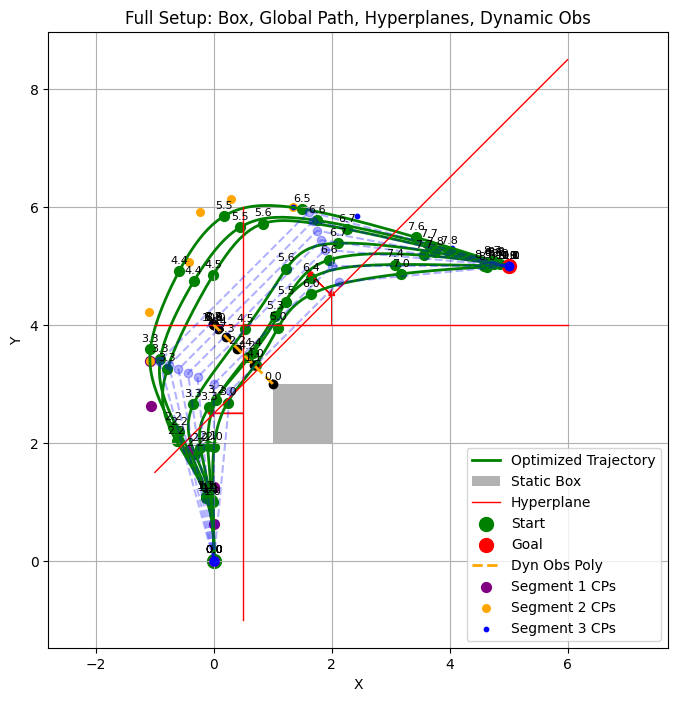

In [130]:
#--- 7) Plot results
# trajectory
plt.figure(figsize=(8,8))

for idx, (z_opt, cp0, t0) in enumerate(zip(z_opts, list_cp0, list_t0)):

    #--- 8) Extract optimized trajectory
    Q_opt, T_opt = reconstruct(z_opt, x0, v0, a0, xf, vf, af, global_wps)

    taus = np.linspace(0, np.sum(T_opt), 200)
    pts_opt = eval_traj(Q_opt, T_opt, 200)
    plt.plot(pts_opt[:,0], pts_opt[:,1], 'g-', lw=2, label='Optimized Trajectory' if idx==0 else None)

    # Plot time stamps along the trajectory
    N_time_samples = 10
    idx_list = np.linspace(0, len(pts_opt)-1, N_time_samples, dtype=int)
    for idx in idx_list:
        plt.scatter(pts_opt[idx,0], pts_opt[idx,1], c='g', s=50)
        plt.text(pts_opt[idx,0], pts_opt[idx,1]+0.1, f'{taus[idx]:.1f}', ha='center', va='bottom', fontsize=8)

# 1) Static box
plt.gca().add_patch(plt.Rectangle((box_x,box_y),box_w,box_h, 
                                facecolor='black',alpha=0.3, label='Static Box'))

# 2) Hyperplanes
x_vals = np.linspace(-1,6,200)
for i,(a,b) in enumerate(zip(A_stat,b_stat)):
    if abs(a[1])>1e-3:
        y_vals = (b - a[0]*x_vals)/a[1]
        plt.plot(x_vals,y_vals,'r-', lw=1, label='Hyperplane' if i==0 else None)
    else:
        xm = b/a[0]
        plt.plot([xm,xm],[-1,6],'r-', lw=1, label='Hyperplane' if i==0 else None)
    # arrow
    if abs(a[1])>1e-3:
        xm = 2.0; ym = (b - a[0]*xm)/a[1]
    else:
        xm = b/a[0]; ym = 2.5
    n = a/np.linalg.norm(a)
    plt.arrow(xm,ym,n[0]*0.5,n[1]*0.5,head_width=0.1,head_length=0.1,color='r')

# 3) Global path
for gwp in global_wps_stacked:
    plt.plot(gwp[:,0], gwp[:,1], 'bo--', alpha=0.3, label='Global Path' if gwp is global_wps[0] else None)

# 4) Start/Goal + init velocity
plt.scatter(x0[0],x0[1],c='green',s=100,label='Start')
plt.arrow(x0[0],x0[1],v0[0],v0[1],head_width=0.1,head_length=0.1,fc='green',ec='green')
plt.scatter(xf[0],xf[1],c='red',s=100,label='Goal')

# 5) Dynamic obstacle polynomial
t_samples = np.linspace(0,T_obs,N_dyn)
t_dense   = np.linspace(0,T_obs,200)
obs_dense = f_obs_poly(t_dense, c_x_obs, c_y_obs)
obs_samp  = f_obs_poly(t_samples, c_x_obs, c_y_obs)
plt.plot(obs_dense[:,0],obs_dense[:,1],'--',color='orange',lw=2,label='Dyn Obs Poly')
plt.scatter(obs_samp[:,0],obs_samp[:,1],c='k')
for (x,y),t in zip(obs_samp,t_samples):
    plt.text(x,y+0.05,f'{t:.1f}',ha='center',va='bottom',fontsize=8)

# 6) Control points (use three different colors for each segment)
cp_opt_flat = Q_opt.reshape(-1,2)
# first segment
plt.scatter(cp_opt_flat[:6,0], cp_opt_flat[:6,1], c='purple', s=50, label='Segment 1 CPs')
# second segment
plt.scatter(cp_opt_flat[6:12,0], cp_opt_flat[6:12,1], c='orange', s=30, label='Segment 2 CPs')
# third segment
plt.scatter(cp_opt_flat[12:,0], cp_opt_flat[12:,1], c='blue', s=10, label='Segment 3 CPs')

plt.axis('equal'); #plt.xlim(-1,6); plt.ylim(-1,6)
plt.xlabel('X'); plt.ylabel('Y')
plt.legend(); plt.grid(True)
plt.title('Full Setup: Box, Global Path, Hyperplanes, Dynamic Obs')
plt.show()

# Plot the velocity and acceleration profiles for the initial trajectory
# plot_velocity_acceleration(Q_opt, T_opt, num_samples=1000)